<h2>Simple NLP project to look for sentiment on a subject in tweets using twitter API, HuggingFace text classification model and visualisation tools.</h2>

<h3>Importing packages and making a query through the Twitter API</h3>

In [7]:
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import config
from wordcloud import WordCloud

client = tweepy.Client(bearer_token=config.BEARER_TOKEN)

query = "Joe Biden -is:retweet lang:en"
                                  
all_tweets = []
for tweet in tweepy.Paginator(client.search_recent_tweets, query=query, tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=1000):
    all_tweets.append(tweet)



<p>We are looking for recent tweets talking about the American president Joe Biden. The query is fetching 1000 tweets</p>

<h3>Importing HuggingFace pipeline for text classification</h3>

In [8]:
from transformers import pipeline

sent_pipeline = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
all_tweets[:3]

[<Tweet id=1613937347212578817 text='Donald Trump was one of the best president ever and Joe Biden is the worst president ever. The way we can get the United States to be as good as it was under Donald Trump is to elect Donald Trump again'>,
 <Tweet id=1613937344515837952 text="What a joke - it's getting better every day dems are trying to save Biden crime family in every possible way let us know who planted them??!National Archive? Crybaby Joe cannot remember his name where or who he is so he will say I didn't do anything wrong https://t.co/Xa5aL36ggc">,
 <Tweet id=1613937334051037184 text='@tedcruz Ashley Biden says that Grandpa Joe died a few years ago and his twin brother has replaced him. Encouraged by the family to do so.'>]

<h3>Transforming into a pandas dataframe</h3>

In [10]:
tweets = []
for tweet in all_tweets:
    tweets.append(tweet.text)

df = pd.DataFrame(tweets)
df.columns = ['tweet']
df.head()

,tweet
0,Donald Trump was one of the best president eve...
1,What a joke - it's getting better every day de...
2,@tedcruz Ashley Biden says that Grandpa Joe di...
3,"Normies: ""Why is Joe Biden talking about stove..."
4,From reports also Iran and Russia as well. ht...


<h3>Sending all the tweets in the pipeline and storing scores in 'sentiment_tweets'</h3>

In [11]:
sentiment_tweets = {}
for label, row in df.iterrows():
    val = sent_pipeline(row.values[0])
    sentiment_tweets[row.name] = {
        'label' : val[0]['label'],
        'score' : val[0]['score']
    }


In [12]:
sentiment_tweets

{0: {'label': 'NEGATIVE', 'score': 0.9995731711387634},
 1: {'label': 'NEGATIVE', 'score': 0.9952045679092407},
 2: {'label': 'POSITIVE', 'score': 0.9828223586082458},
 3: {'label': 'NEGATIVE', 'score': 0.9988939166069031},
 4: {'label': 'NEGATIVE', 'score': 0.9382671117782593},
 5: {'label': 'NEGATIVE', 'score': 0.9961439371109009},
 6: {'label': 'NEGATIVE', 'score': 0.9778861999511719},
 7: {'label': 'NEGATIVE', 'score': 0.9919678568840027},
 8: {'label': 'NEGATIVE', 'score': 0.9974574446678162},
 9: {'label': 'NEGATIVE', 'score': 0.9801701903343201},
 10: {'label': 'NEGATIVE', 'score': 0.9992499947547913},
 11: {'label': 'NEGATIVE', 'score': 0.9985180497169495},
 12: {'label': 'NEGATIVE', 'score': 0.9919561147689819},
 13: {'label': 'NEGATIVE', 'score': 0.9976801872253418},
 14: {'label': 'POSITIVE', 'score': 0.9951719641685486},
 15: {'label': 'NEGATIVE', 'score': 0.9993095397949219},
 16: {'label': 'POSITIVE', 'score': 0.9997397065162659},
 17: {'label': 'NEGATIVE', 'score': 0.979

<h3>Transforming 'sentiment_tweets' in a dataframe and merging the 'df' dataframe into it</h3>

In [13]:
sentiment_tweets = pd.DataFrame(sentiment_tweets)
sentiment_tweets = sentiment_tweets.T

In [14]:
sentiment_tweets.head()

,label,score
0,NEGATIVE,0.999573
1,NEGATIVE,0.995205
2,POSITIVE,0.982822
3,NEGATIVE,0.998894
4,NEGATIVE,0.938267


In [15]:
sentiment_tweets = sentiment_tweets.merge(df, how="right", right_index=True, left_index=True)
sentiment_tweets.head()

,label,score,tweet
0,NEGATIVE,0.999573,Donald Trump was one of the best president eve...
1,NEGATIVE,0.995205,What a joke - it's getting better every day de...
2,POSITIVE,0.982822,@tedcruz Ashley Biden says that Grandpa Joe di...
3,NEGATIVE,0.998894,"Normies: ""Why is Joe Biden talking about stove..."
4,NEGATIVE,0.938267,From reports also Iran and Russia as well. ht...


<h3>Modifying types</h3>

In [16]:
sentiment_tweets.dtypes

label    object
score    object
tweet    object
dtype: object

In [17]:
sentiment_tweets = sentiment_tweets.astype('string')
sentiment_tweets['score'] = sentiment_tweets['score'].astype('float')
sentiment_tweets.dtypes

label     string
score    float64
tweet     string
dtype: object

<h3>Distribution of sentiment</h3>

<AxesSubplot: xlabel='label', ylabel='count'>

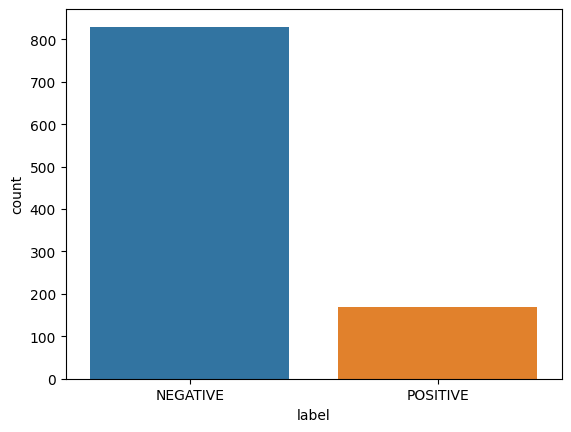

In [18]:
sns.countplot(x='label', data=sentiment_tweets)

<h3>Visualising most used words in tweets</h3>

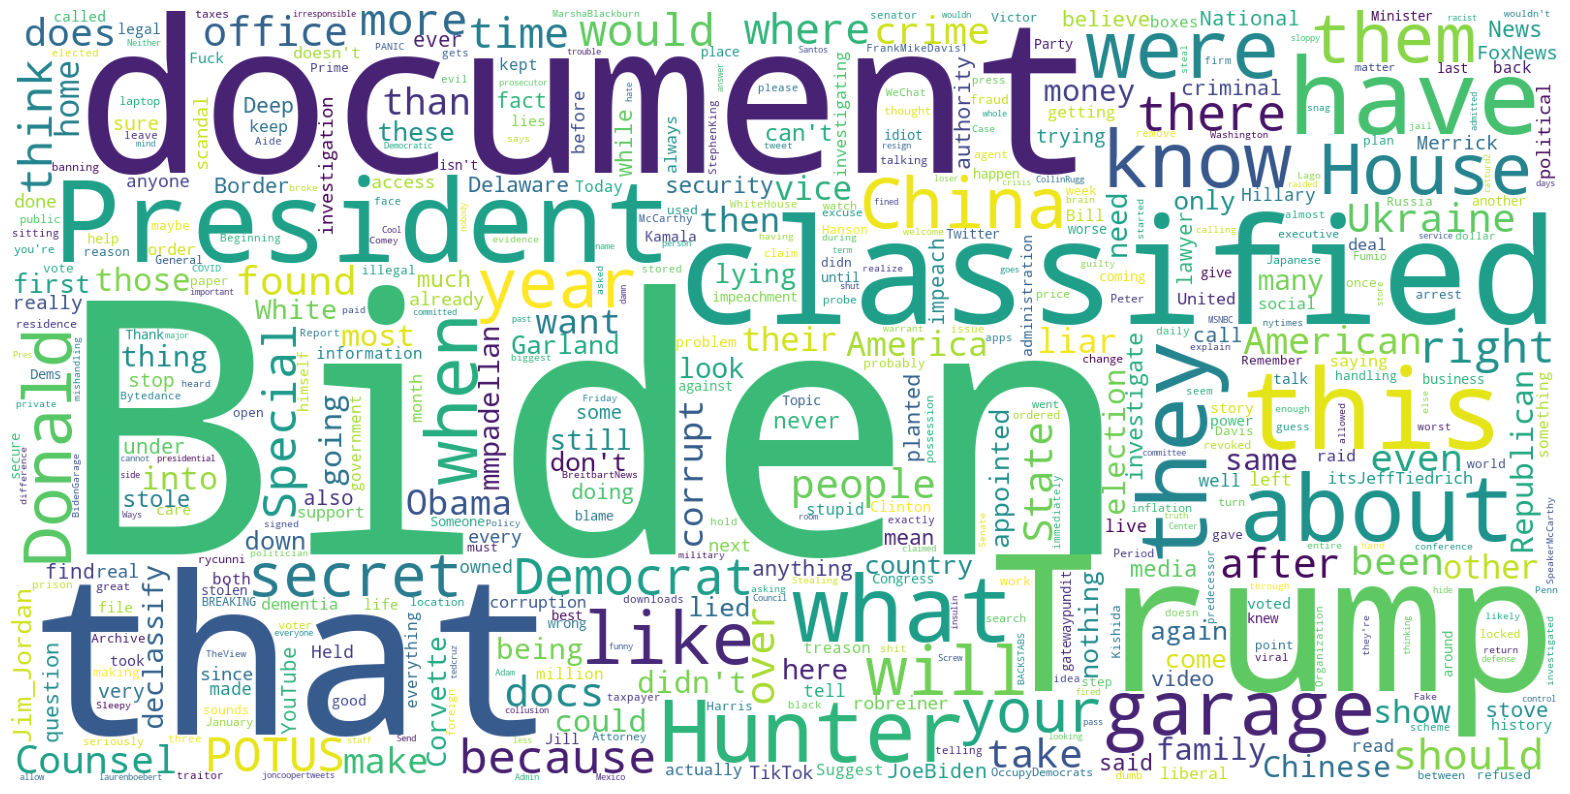

In [21]:
data = sentiment_tweets['tweet']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500, width = 1600 , height = 800,
               collocations=False, min_word_length=4, normalize_plurals=True,background_color="white", stopwords=["https", "from", "which", "with", "just"]).generate(" ".join(data))
plt.axis("off")
plt.imshow(wc)